[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# Kernel Regression

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 01/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0050RegressorKernel.ipynb)

In [11]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.linear_model import HuberRegressor, LinearRegression ,RANSACRegressor

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [12]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [13]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2


In [14]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotRegressionData


In [15]:
# General Auxiliary Functions



## Kernel Regression

_Kernel Regression_ is a non parametric regression method.

In this notebook we'll show the effect of a different kernel and bandwidth on the estimation.  
We'll also show the performance difference between _interpolation_ and _extrapolation_ in the context of Kernel Regression.

* <font color='brown'>(**#**)</font> The Kernel Regression approach is mostly popular among statisticians in the context of Kernel Density Estimation (KDE). Namely estimating the PDF of a data.


In [16]:
# Parameters

# Data Generation
numSamples  = 200
noiseStd    = 0.01

# Data Visualization
gridNoiseStd = 0.05
numGridPts   = 500

## Generate / Load Data

In the following we'll generate data according to the following model:

$$ y_{i} = f \left( x_{i} \right) + \epsilon_{i} $$

Where

$$ f \left( x \right) = 5 \exp \left( - x \right) \sin \left( 10 x + 0.5 \right) + \left( 1 + 10 \mathcal{I}_{x > 2} \left( x - 2 \right) \right) + 1 $$


In [17]:
# The Data Generating Function

def f( vX: np.ndarray ):
    
    return 5 * np.exp(-vX) * np.sin(10 * vX + 0.5) * (1 + 10 * (vX > 2) * (vX - 2)) + 1

In [18]:
# Generate Data

vX = 4 * np.sort(np.random.rand(numSamples))
vY = f(vX) + (noiseStd * np.random.randn(numSamples))

print(f'The features data shape: {vX.shape}')
print(f'The labels data shape: {vY.shape}')

The features data shape: (200,)
The labels data shape: (200,)


### Plot Data

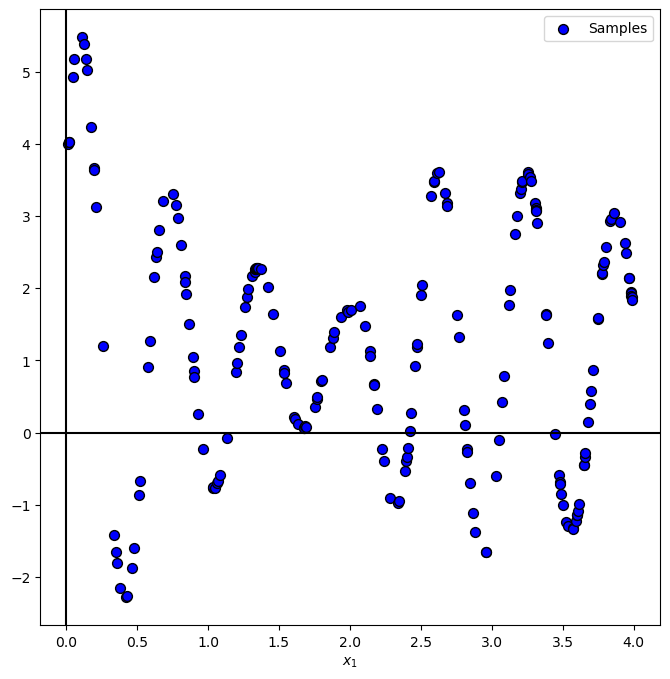

In [19]:
# Plot the Data

PlotRegressionData(vX, vY)

plt.show()


## Regression Kernels

Some of the common kernels are:

 - Uniform: $k\left(u\right)=\begin{cases}1 & \left|u\right|\leq\frac{1}{2}\\0 & \text{else}\end{cases}$.
 - Triangular: $k\left(u\right)=\begin{cases}1-\left|u\right| & \left|u\right|\leq1\\0 & \text{else}\end{cases}$.
 - Gaussian: $k\left(u\right)=e^{-\frac{1}{2}u^{2}}$.
 - Cosine: $k\left(u\right)=\begin{cases}1+\cos\left(\pi u\right) & \left|u\right|\leq1\\0 & \text{else}\end{cases}$.

In [20]:
# Defining the Kernels

def UniformKernel( vU: np.ndarray ):
    return 1 * (np.abs(vU) < 0.5)               ### *1 is used to convert the boolean to integer !!! ###

def TriangularKernel( vU: np.ndarray ):
    return (np.abs(vU) < 1) * (1 - np.abs(vU))

def GaussianKernel( vU: np.ndarray ):
    return np.exp(-0.5 * np.square(vU))

def CosineKernel( vU: np.ndarray ):
    return (np.abs(vU) < 1) * (1 + np.cos(np.pi * vU))

lKernels = [('Uniform', UniformKernel), ('Triangular', TriangularKernel), ('Gaussian', GaussianKernel), ('Cosine', CosineKernel)]

* <font color='brown'>(**#**)</font> In the context of _Signal Processing_ the kernels above are known as a _Window Function_.

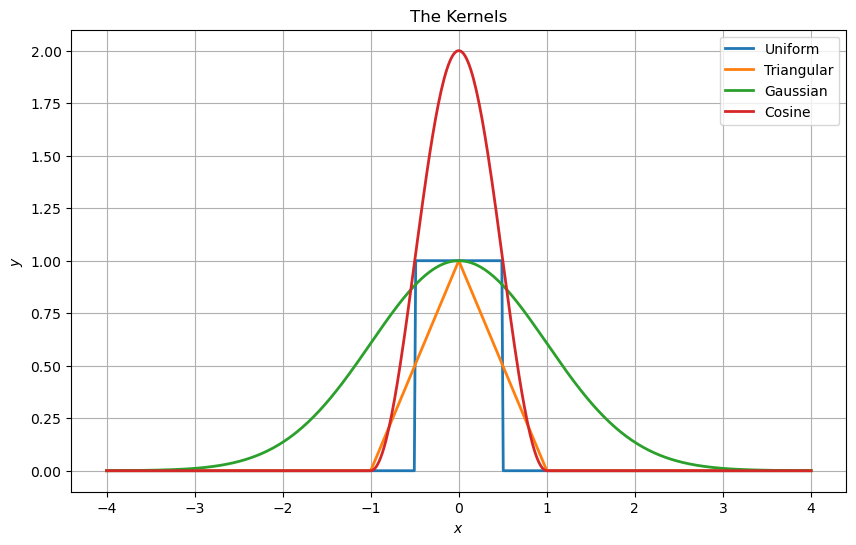

In [21]:
# Plotting the Kernels

hF, hA = plt.subplots(figsize = (10, 6))
vG = np.linspace(-4, 4, numGridPts)

for ii, (kernelLabel, hKernel) in enumerate(lKernels):
    hA.plot(vG, hKernel(vG), lw = 2, label = kernelLabel)

hA.set_xlabel('$x$')
hA.set_ylabel('$y$')
hA.set_title('The Kernels')
hA.legend()
hA.grid()

plt.show()

the cos here at the peak is 2 and all other are 1, why?
* all function will be normalized - so it is irrelevant.


## Kernel Regression

The kernel regression operation is defined by:

$$\boxed{\hat{f} \left( x \right) = \frac{\sum_{i = 1}^{N} w_{x} \left( {x}_{i} \right) {y}_{i}}{\sum_{i = 1}^{N} {w}_{x} \left( {x}_{i} \right)}}$$

Where ${w}_{x} \left( {x}_{i} \right) = k \left( \frac{ x - x_{i} }{ h } \right)$.


* <font color='brown'>(**#**)</font> In the context of _Signal Processing_ the operation above is basically a convolution.

In [28]:
a=[1,2,3,4,5,6,7,8,9,10]
a=np.array(a)
print(a)
print(a[:,None])
print(a[None,:])

[ 1  2  3  4  5  6  7  8  9 10]
[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
[[ 1  2  3  4  5  6  7  8  9 10]]


In [22]:
# Applying and Plotting the Kernels

def ApplyKernel( hKernel: Callable[np.ndarray, np.ndarray], paramH: float, vX: np.ndarray, vY: np.ndarray, vG: np.ndarray, zeroThr: float = 1e-9 ) -> np.ndarray:

    mW = hKernel((vG[:, None] - vX[None, :]) / paramH)
    # vYPred = (mW @ vY) / np.sum(mW, axis = 1)
    vK = mW @ vY #<! For numerical stability, removing almost zero values
    vW = np.sum(mW, axis = 1)
    vI = np.abs(vW) < zeroThr #<! Calculate only when there's real data
    vK[vI] = 0
    vW[vI] = 1 #<! Remove cases of dividing by 0
    vYPred = vK / vW

    return vYPred


vG = np.linspace(-0.2, 4.5, 1000, endpoint = True)

def PlotKernelRegression( hKernel: Callable[np.ndarray, np.ndarray], paramH: float, vX: np.ndarray, vY: np.ndarray, vG: np.ndarray, figSize = FIG_SIZE_DEF, hA = None ):

    if hA is None:
        hF, hA = plt.subplots(figsize = figSize)
    else:
        hF = hA.get_figure()
    
    vYPred = ApplyKernel(hKernel, paramH, vX, vY, vG)
    
    hA.plot(vG, vYPred, 'b', lw = 2, label = '$\hat{f}(x)$')
    hA.scatter(vX, vY, s = 50, c = 'r', edgecolor = 'k', label = '$y_i = f(x_i) + \epsilon_i$')
    hA.set_title(f'Kernel Regression with h = {paramH}')
    hA.set_xlabel('$x$')
    hA.set_ylabel('$y$')
    hA.grid()
    hA.legend(loc = 'lower right')

In [23]:
hPlotKernelRegression = lambda hK, paramH: PlotKernelRegression(hK, paramH, vX, vY, vG)

hSlider        = FloatSlider(min = 0.001, max = 2.5, step = 0.001, value = 0.01, readout_format = '0.3f', layout = Layout(width = '30%'))
kernelDropdown = Dropdown(options = lKernels, value = GaussianKernel, description = 'Kernel:')
interact(hPlotKernelRegression, hK = kernelDropdown, paramH = hSlider)
plt.show()

interactive(children=(Dropdown(description='Kernel:', index=2, options=(('Uniform', <function UniformKernel at…

* <font color='blue'>(**!**)</font> Play with the number of samples of the data to see its effect.
* <font color='red'>(**?**)</font> What happens outside of the data samples? What does it mean for real world data?

exterpolution is dumping to zero : 

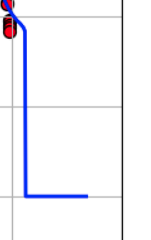